In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
    .appName("Parquet EDA") \
    .getOrCreate()

24/05/06 16:40:52 WARN Utils: Your hostname, seons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.25.172.138 instead (on interface en0)
24/05/06 16:40:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 16:40:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
parquet_directory = "/Users/seonminhwang/Downloads/yellow_tripdata_2024-01.parquet"

In [4]:
df = spark.read.parquet(parquet_directory)
df.head()

Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2024, 1, 1, 0, 57, 55), tpep_dropoff_datetime=datetime.datetime(2024, 1, 1, 1, 17, 43), passenger_count=1, trip_distance=1.72, RatecodeID=1, store_and_fwd_flag='N', PULocationID=186, DOLocationID=79, payment_type=2, fare_amount=17.7, extra=1.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=1.0, total_amount=22.7, congestion_surcharge=2.5, Airport_fee=0.0)

In [5]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



## Histogram of Taxi by 1 Hour-Block

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth, hour, minute, second

sampled_df = df.sample(fraction=0.15, withReplacement=False)
spark = SparkSession.builder.appName("Datetime Example").getOrCreate()

sampled_df_time = sampled_df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
sampled_df_time = sampled_df_time.withColumn("year", year("tpep_pickup_datetime")) \
       .withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day", dayofmonth("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime")) \
       .withColumn("minute", minute("tpep_pickup_datetime")) \
       .withColumn("second", second("tpep_pickup_datetime"))

sampled_df_time.show()

24/05/06 16:40:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+---+----+------+------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|year|month|day|hour|minute|second|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+---+----+------+------+
|       1| 2024-01-01 00:30:40|  2024-01-01 00:58:40|              0|          3.0|  

In [7]:
pandas_time_df = sampled_df_time.select("year","month","day","hour","minute","second","Extra","fare_amount", "trip_distance").toPandas()
pandas_time_df['Amount_per_Distance'] = pandas_time_df["fare_amount"]/pandas_time_df["trip_distance"]
pandas_time_df

,year,month,day,hour,minute,second,Extra,fare_amount,trip_distance,Amount_per_Distance
0,2024,1,1,0,30,40,3.50,25.40,3.00,8.466667
1,2024,1,1,0,52,9,1.00,3.00,0.00,inf
2,2024,1,1,0,20,11,1.00,28.90,5.88,4.914966
3,2024,1,1,0,49,31,1.00,47.80,8.89,5.376828
4,2024,1,1,0,58,18,1.00,14.20,2.23,6.367713
...,...,...,...,...,...,...,...,...,...,...
444454,2024,1,31,23,9,56,0.00,21.93,3.39,6.469027
444455,2024,1,31,23,39,20,1.75,70.00,19.10,3.664921
444456,2024,1,31,23,3,0,0.00,6.83,0.54,12.648148
444457,2024,1,31,23,53,31,0.00,16.00,2.90,5.517241


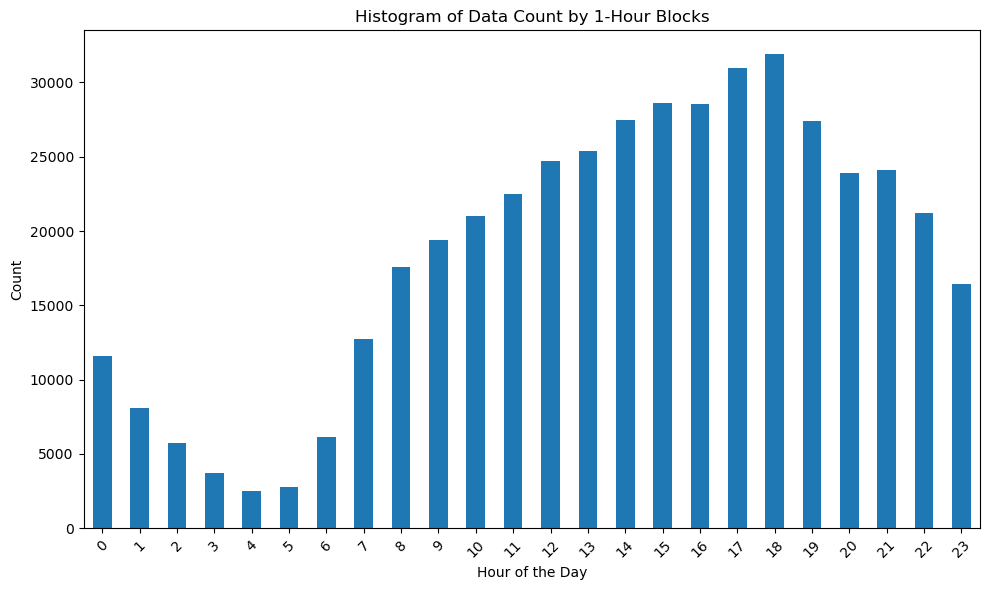

In [8]:
import matplotlib.pyplot as plt

time_block_counts = pandas_time_df.groupby('hour').size()

plt.figure(figsize=(10, 6))
time_block_counts.plot(kind='bar')
plt.title('Histogram of Data Count by 1-Hour Blocks')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

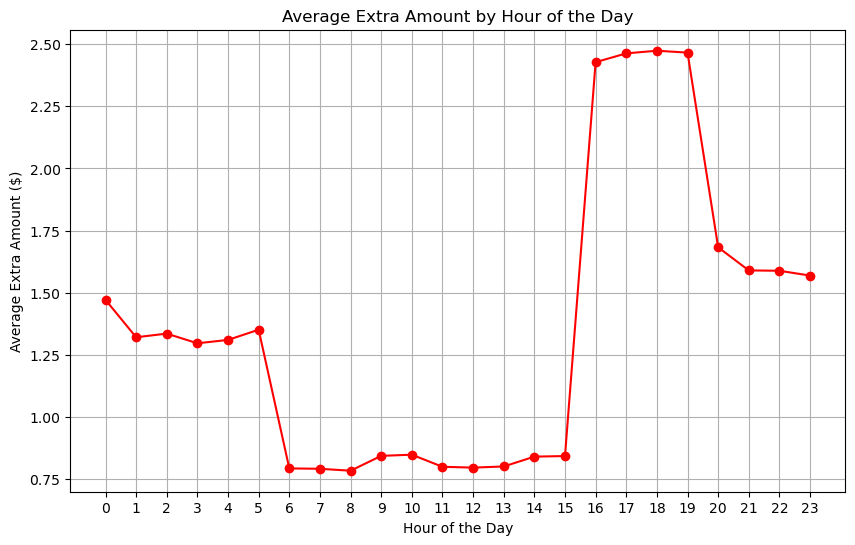

In [9]:
hourly_avg = pandas_time_df.groupby('hour')['Extra'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='red')
plt.title('Average Extra Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Extra Amount ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

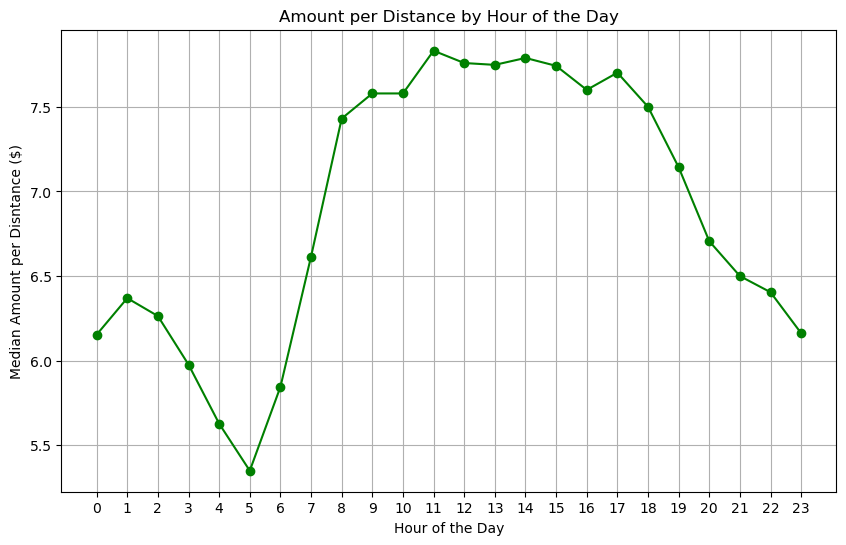

In [10]:
avg = pandas_time_df.groupby('hour')['Amount_per_Distance'].median()

plt.figure(figsize=(10, 6))
plt.plot(avg.index, avg.values, marker='o', color='green')
plt.title('Amount per Distance by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Median Amount per Disntance ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()